# Лабораторная работа №3: Наивный байесовский классификатор

## 1. Загрузка и предобработка данных (Red Wine Quality)

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from my_naive_bayes import MyGaussianNB
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка отображения
plt.style.use('default')
sns.set_theme()
%matplotlib inline

In [32]:
# Загрузка датасета
df = pd.read_csv('winequality-red.csv', sep=',')

# Проверка загрузки данных
print('Размерность датасета:', df.shape)
print('\nНазвания столбцов:')
print(df.columns.tolist())
print('\nПервые 5 строк:')
display(df.head())

# Проверка типов данных
print('\nТипы данных:')
print(df.dtypes)

Размерность датасета: (1599, 12)

Названия столбцов:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Первые 5 строк:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5



Типы данных:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


In [33]:
# Анализ данных
print('\nСтатистика датасета:')
display(df.describe())

print('\nРаспределение качества вина:')
print(df['quality'].value_counts().sort_index())


Статистика датасета:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000



Распределение качества вина:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


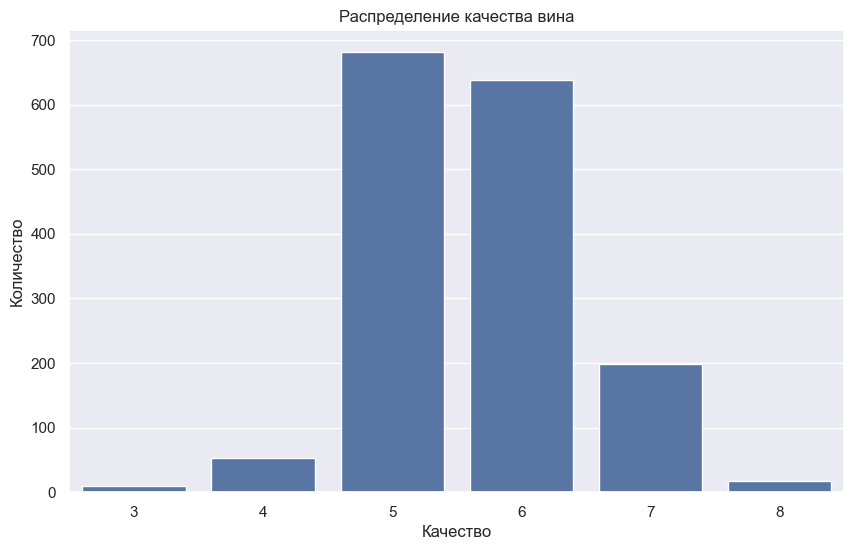

In [34]:
# Визуализация распределения качества
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='quality')
plt.title('Распределение качества вина')
plt.xlabel('Качество')
plt.ylabel('Количество')
plt.show()

In [35]:
# Бинаризация целевой переменной
df['quality_bin'] = (df['quality'] >= 6).astype(int)
print('Распределение классов после бинаризации:')
print(df['quality_bin'].value_counts())

Распределение классов после бинаризации:
quality_bin
1    855
0    744
Name: count, dtype: int64


In [36]:
# Разделение на признаки и целевую переменную
X = df.drop(['quality', 'quality_bin'], axis=1)
y = df['quality_bin']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Размерность X:', X.shape)
print('Размерность y:', y.shape)

Размерность X: (1599, 11)
Размерность y: (1599,)


## 2. Сравнение собственной реализации и sklearn GaussianNB

In [37]:
def cross_validation_evaluation(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    training_times = []
    
    # Замер времени обучения
    for train_idx, _ in skf.split(X, y):
        X_train = X[train_idx]
        y_train = y[train_idx]
        start_time = time.time()
        model.fit(X_train, y_train)
        training_times.append(time.time() - start_time)
    
    # Кросс-валидация для точности
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    
    return cv_scores, np.mean(training_times)

In [47]:
# Оценка собственной реализации
my_cv_scores, my_cv_time = cross_validation_evaluation(MyGaussianNB(), X_scaled, y)
print(f'Собственная реализация:')
print(f'Средняя точность: {my_cv_scores.mean():.4f} (±{my_cv_scores.std():.4f})')
print(f'Среднее время обучения: {my_cv_time:.4f} сек')

# Оценка sklearn реализации
sk_cv_scores, sk_cv_time = cross_validation_evaluation(GaussianNB(), X_scaled, y)
print(f'\nSklearn реализация:')
print(f'Средняя точность: {sk_cv_scores.mean():.4f} (±{sk_cv_scores.std():.4f})')
print(f'Среднее время обучения: {sk_cv_time:.4f} сек')

Собственная реализация:
Средняя точность: 0.7298 (±0.0313)
Среднее время обучения: 0.0005 сек

Sklearn реализация:
Средняя точность: 0.7298 (±0.0313)
Среднее время обучения: 0.0001 сек
